In [1]:
import sys
import os
from collections import Counter
import sklearn
import psutil
import numpy as np
import time
from loguru import logger

import pandas as pd
# import scanpy as sc
from tqdm import tqdm
import random

import multiprocessing
import anndata as ad
import gc
import pickle

In [2]:
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import umap

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch

# train projections

In [4]:
adata_ori = sc.read_h5ad("/nfs/public/cell_gpt_data/dataHub/datasets/experiment/RealData_HSC.h5ad")

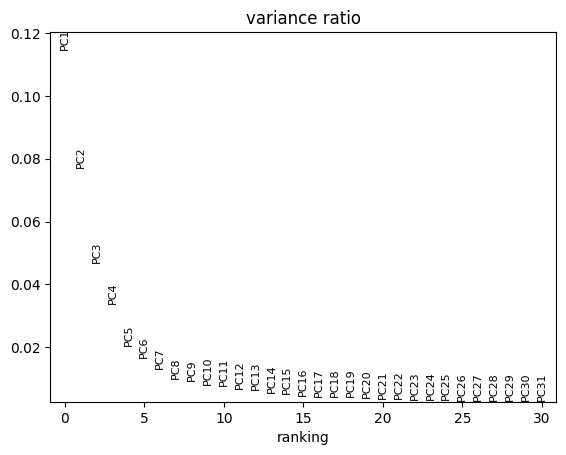

In [5]:
sc.pp.pca(adata_ori)
sc.pl.pca_variance_ratio(adata_ori)

In [6]:
pca=PCA(n_components = 10, svd_solver='arpack',random_state=42)
X_pca = pca.fit_transform(adata_ori.X)
umap_=umap.UMAP(n_neighbors=30)
proj = umap_.fit_transform(X_pca)

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
adata_ori.obsm['X_pca'] = X_pca
adata_ori.obsm['X_umap'] = proj

In [8]:
adata_ori.obs.cell_type.unique()

['Megakaryocyte', 'Megakaryocyte-erythrocyte progenitor (MEP)', 'Basophilic granulocyte', 'Haematopoietic stem cell', 'Granulocyte-monocyte progenitor (GMP)', ..., 'Erythrocyte', 'Common lymphoid progenitor (CLP)', 'Erythroid progenitor cell', 'NK T cell', 'Pro-B cell']
Length: 13
Categories (13, object): ['Basophilic granulocyte', 'Common lymphoid progenitor (CLP)', 'Erythrocyte', 'Erythroid progenitor cell', ..., 'Monocyte', 'NK T cell', 'Plasmacytoid dendritic cell', 'Pro-B cell']

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


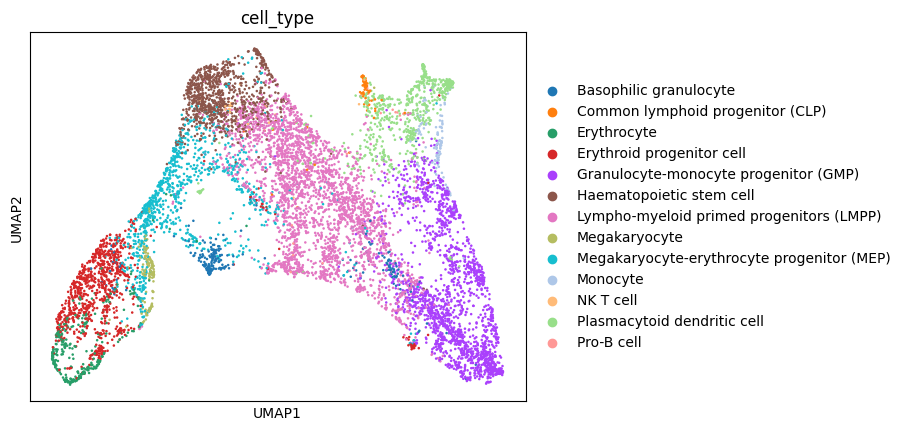

In [9]:
sc.pl.umap(adata_ori,color=['cell_type'])

In [10]:
torch.save(pca,"/nfs/public/cell_gpt_data/dataHub/datasets/experiment/model/Screen_gene_pca_model.pt")
torch.save(umap_,"/nfs/public/cell_gpt_data/dataHub/datasets/experiment/model/Screen_gene_umap_model.pt")

# Process generated data

In [11]:
adata_gen =  sc.read_h5ad("/nfs/public/cell_gpt_data/dataHub/generated_cells/denovo_generation/allgenes_perturb_hsc.h5ad")
adata_gen.X = adata_gen.X/10

In [12]:
adata_gen.obs.perturbed_gene.value_counts()

perturbed_gene
None      40000
None-0    40000
OSMR        200
PAMR1       200
PALMD       200
          ...  
FOLR3       200
FOLR2       200
FOLH1       200
FN1         200
ZNF831      200
Name: count, Length: 2002, dtype: int64

In [13]:
adata_gen = adata_gen[adata_gen.obs.perturbed_gene!="None",:]
adata_gen = adata_gen[adata_gen.obs.perturbed_gene!="None-0",:]

In [ ]:
adata_gen.obsm['X_pca'] = pca.transform(np.array(adata_gen.X.todense()))
adata_gen.obsm['X_umap'] = umap_.transform(adata_gen.obsm['X_pca'])

/tmp/ipykernel_1013459/519044027.py:1: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata_gen.obsm['X_pca'] = pca.transform(np.array(adata_gen.X.todense()))


/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


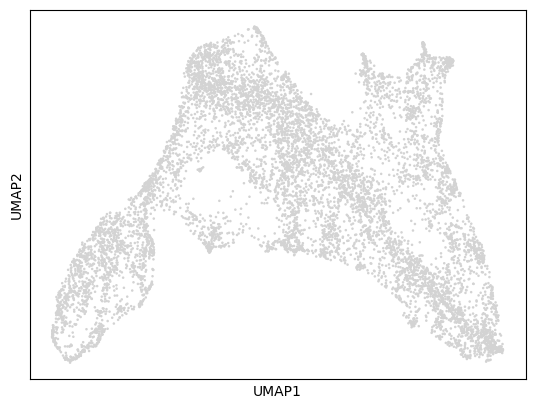

In [ ]:
sc.pl.umap(adata_ori)

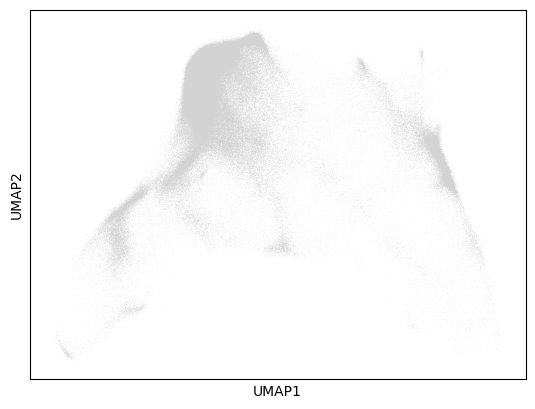

In [ ]:
sc.pl.umap(adata_gen)

# Get centroids

In [18]:
HSC_centroid = adata_ori.obsm['X_umap'][adata_ori.obs.cell_type == 'Haematopoietic stem cell'].mean(axis=0)

In [19]:
adata_gen.obs['perturbed_pair'] = adata_gen.obs['perturbed_gene'].astype(str) + '_' + adata_gen.obs['perturbed_value'].astype(str)
df = pd.DataFrame({
    "UMAP_1":adata_gen.obsm["X_umap"][:,0],
    "UMAP_2":adata_gen.obsm["X_umap"][:,1],
    "group":adata_gen.obs.perturbed_pair
})
df_centroids = df.groupby('group')[['UMAP_1', 'UMAP_2']].mean()

df_vectors = df_centroids - HSC_centroid

# Visualization

In [ ]:
def plot_centroids(gene,ax,init=1):    
    centroids = df_centroids.loc[[gene+f"_{i}" for i in range(init,11)],:]
    for i in range(10-init):
        ax.plot([centroids.iloc[i]['UMAP_1'], centroids.iloc[i+1]['UMAP_1']], 
                 [centroids.iloc[i]['UMAP_2'], centroids.iloc[i+1]['UMAP_2']], 
                 color='black', linestyle='--')
        
    ax.scatter(centroids.loc[:,"UMAP_1"],centroids.loc[:,"UMAP_2"], marker='o')
    
    legend_markers = []
    ax.scatter(x=HSC_centroid[0], y=HSC_centroid[1], marker='x')
    ax.plot([HSC_centroid[0], centroids.iloc[0]['UMAP_1']], 
                 [HSC_centroid[1], centroids.iloc[0]['UMAP_2']], 
                 color='black', linestyle='--')
    ax.set_title(gene)

# get score

In [21]:
MEP_centroid = adata_ori.obsm['X_umap'][adata_ori.obs.cell_type == 'Megakaryocyte-erythrocyte progenitor (MEP)'].mean(axis=0)
Erythrocyte_centroid = adata_ori.obsm['X_umap'][adata_ori.obs.cell_type == 'Erythrocyte'].mean(axis=0)
LMPP_centroid = adata_ori.obsm['X_umap'][adata_ori.obs.cell_type == 'Lympho-myeloid primed progenitors (LMPP)'].mean(axis=0)
GMP_centroid = adata_ori.obsm['X_umap'][adata_ori.obs.cell_type == 'Granulocyte-monocyte progenitor (GMP)'].mean(axis=0)

In [23]:
vector_left = MEP_centroid - HSC_centroid
vector_right = LMPP_centroid - HSC_centroid

In [24]:
df_score = pd.DataFrame(np.zeros_like(df_vectors), index=df_vectors.index, columns= ['cos_left', 'cos_right'])
df_score['length'] = 0

In [25]:
for i in tqdm(range(df_vectors.shape[0])):
    df_score.iloc[i,2] = np.linalg.norm(df_vectors.iloc[i,:])
    df_score.iloc[i,0] = np.array(df_vectors.iloc[i,:])@vector_left/np.linalg.norm(vector_left)
    df_score.iloc[i,1] = np.array(df_vectors.iloc[i,:])@vector_right/np.linalg.norm(vector_right)

100%|██████████| 20000/20000 [00:08<00:00, 2340.55it/s]


In [26]:
df_score

,cos_left,cos_right,length
group,,,
A2M_1,0.593540,-0.741391,1.026984
A2M_10,0.153428,2.716738,2.728216
A2M_2,0.528797,-0.905034,1.125813
A2M_3,0.076814,-1.079206,1.105266
A2M_4,0.152661,-0.679540,0.726050
...,...,...,...
ZNF831_5,0.956715,0.345827,0.978850
ZNF831_6,0.757940,0.643392,0.929172
ZNF831_7,1.008928,1.063677,1.368772


In [27]:
df_score.cos_left = df_score.cos_left/df_score.length
df_score.cos_right = df_score.cos_right/df_score.length

df_score['cos_left_FC'] = df_score.cos_left/abs(df_score.cos_right)
df_score['cos_right_FC'] = df_score.cos_right/abs(df_score.cos_left)

In [28]:
df_score

,cos_left,cos_right,length,cos_left_FC,cos_right_FC
group,,,,,
A2M_1,0.577945,-0.721911,1.026984,0.800576,-1.249100
A2M_10,0.056237,0.995793,2.728216,0.056475,17.706960
A2M_2,0.469702,-0.803894,1.125813,0.584283,-1.711498
A2M_3,0.069499,-0.976422,1.105266,0.071177,-14.049527
A2M_4,0.210262,-0.935942,0.726050,0.224653,-4.451314
...,...,...,...,...,...
ZNF831_5,0.977387,0.353299,0.978850,2.766461,0.361473
ZNF831_6,0.815715,0.692436,0.929172,1.178037,0.848870
ZNF831_7,0.737105,0.777103,1.368772,0.948529,1.054264


In [29]:
df_centroids.to_csv("/nfs/public/chenyx/scMulan_test/screen_gene/centroids.csv")
df_score.to_csv("/nfs/public/chenyx/scMulan_test/screen_gene/score_2branches.csv")
df_vectors.to_csv("/nfs/public/chenyx/scMulan_test/screen_gene/vectores.csv")

# score for overexpress to 1.0

In [30]:
df_HSC = pd.DataFrame(adata_ori[adata_ori.obs.cell_type=='Haematopoietic stem cell',].X,columns=adata_ori.var_names)

(array([1.915e+03, 0.000e+00, 4.900e+01, 0.000e+00, 1.400e+01, 1.100e+01,
        7.000e+00, 0.000e+00, 3.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

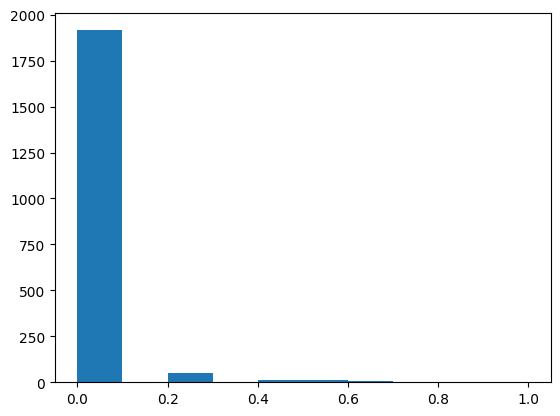

In [31]:
plt.hist(df_HSC.median(),bins=10)

(array([1.293e+03, 2.610e+02, 1.500e+02, 9.500e+01, 8.600e+01, 6.500e+01,
        4.200e+01, 6.000e+00, 1.000e+00, 1.000e+00]),
 array([0.        , 0.02362514, 0.04725028, 0.07087541, 0.09450055,
        0.11812569, 0.14175083, 0.16537597, 0.1890011 , 0.21262624,
        0.23625138]),
 <BarContainer object of 10 artists>)

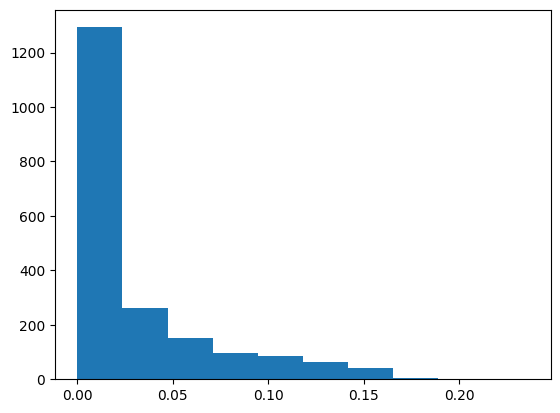

In [32]:
plt.hist(df_HSC.std(),bins=10)

In [36]:
init_value_list = (df_HSC.median()*10+1).astype(int)

In [37]:
df_average_score = pd.DataFrame(np.zeros([2000,5]),index=adata_gen.obs['perturbed_gene'].unique(), columns=['cos_left', 'cos_right', 'length', 'cos_left_FC', 'cos_right_FC'])
for gene in tqdm(adata_gen.obs['perturbed_gene'].unique()):
    df_average_score.loc[gene,:] = df_score.loc[[f"{gene}_{i}" for i in range(max(init_value_list[gene],10),11)]].iloc[:,0:5].mean()

100%|██████████| 2000/2000 [00:02<00:00, 801.38it/s]


In [173]:
df_average_score

,cos_left,cos_right,length,cos_left_FC,cos_right_FC,cos_left_FC2,cos_right_FC2,score_left,score_right
A2M,0.056237,0.995793,2.728216,0.056475,17.706960,0.154076,48.308411,0.153428,2.716738
ABCA1,0.907838,-0.280839,1.439675,3.232595,-0.309349,4.653887,-0.445362,1.306992,-0.404317
ABCA6,0.767288,0.747455,1.264512,1.026534,0.974152,1.298065,1.231827,0.970245,0.945167
ABCA8,0.947837,-0.175474,4.117303,5.401587,-0.185131,22.239970,-0.762239,3.902533,-0.722479
ABCA9,0.945603,-0.182298,3.828748,5.187125,-0.192785,19.860192,-0.738125,3.620476,-0.697974
...,...,...,...,...,...,...,...,...,...
ZNF683,-0.219436,0.932593,5.237373,-0.235296,4.249962,-1.232334,22.258636,-1.149266,4.884336
ZNF80,0.574364,0.894360,1.546946,0.642207,1.557131,0.993459,2.408798,0.888510,1.383527
ZNF804A,0.102792,0.998985,3.004826,0.102896,9.718513,0.309186,29.202439,0.308872,3.001776
ZNF804B,0.056466,0.995814,1.383555,0.056704,17.635492,0.078453,24.399679,0.078124,1.377764


In [174]:
df_average_score.to_csv("/nfs/public/chenyx/scMulan_test/screen_gene/score_2branches_2K.csv")

In [40]:
df_average_score['cos_left_FC2'] = df_average_score.cos_left_FC*df_average_score.length
df_average_score['cos_right_FC2'] = df_average_score.cos_right_FC*df_average_score.length

In [50]:
df_average_score['score_left'] = df_average_score.cos_left*df_average_score.length
df_average_score['score_right'] = df_average_score.cos_right*df_average_score.length

In [51]:
df_average_score

,cos_left,cos_right,length,cos_left_FC,cos_right_FC,cos_left_FC2,cos_right_FC2,score_left,score_right
A2M,0.056237,0.995793,2.728216,0.056475,17.706960,0.154076,48.308411,0.153428,2.716738
ABCA1,0.907838,-0.280839,1.439675,3.232595,-0.309349,4.653887,-0.445362,1.306992,-0.404317
ABCA6,0.767288,0.747455,1.264512,1.026534,0.974152,1.298065,1.231827,0.970245,0.945167
ABCA8,0.947837,-0.175474,4.117303,5.401587,-0.185131,22.239970,-0.762239,3.902533,-0.722479
ABCA9,0.945603,-0.182298,3.828748,5.187125,-0.192785,19.860192,-0.738125,3.620476,-0.697974
...,...,...,...,...,...,...,...,...,...
ZNF683,-0.219436,0.932593,5.237373,-0.235296,4.249962,-1.232334,22.258636,-1.149266,4.884336
ZNF80,0.574364,0.894360,1.546946,0.642207,1.557131,0.993459,2.408798,0.888510,1.383527
ZNF804A,0.102792,0.998985,3.004826,0.102896,9.718513,0.309186,29.202439,0.308872,3.001776
ZNF804B,0.056466,0.995814,1.383555,0.056704,17.635492,0.078453,24.399679,0.078124,1.377764


# check TF

In [5]:
df_average_score = pd.read_csv("/nfs/public/chenyx/scMulan_test/screen_gene/score_2branches_2K.csv",index_col=0)

In [6]:
TF_list = pd.read_csv("TF_names_v_1.01.txt",header=None)[0].values
df_average_score_TF = df_average_score.loc[df_average_score.index.isin(TF_list),:]


In [7]:
df_average_score_TF

,cos_left,cos_right,length,cos_left_FC,cos_right_FC,cos_left_FC2,cos_right_FC2,score_left,score_right
AEBP1,0.900297,0.563300,2.059270,1.598253,0.625683,3.291235,1.288450,1.853954,1.159987
ARID5B,0.920941,0.521269,0.731952,1.766730,0.566018,1.293162,0.414298,0.674085,0.381544
ATF3,-0.691123,-0.816766,0.104394,-0.846170,-1.181796,-0.088335,-0.123372,-0.072149,-0.085265
BACH2,0.999987,0.142524,1.557793,7.016263,0.142526,10.929885,0.222026,1.557773,0.222023
BATF,0.579330,0.891623,0.572786,0.649748,1.539059,0.372167,0.881552,0.331833,0.510710
...,...,...,...,...,...,...,...,...,...
ZNF683,-0.219436,0.932593,5.237373,-0.235296,4.249962,-1.232334,22.258636,-1.149266,4.884336
ZNF80,0.574364,0.894360,1.546946,0.642207,1.557131,0.993459,2.408798,0.888510,1.383527
ZNF804A,0.102792,0.998985,3.004826,0.102896,9.718513,0.309186,29.202439,0.308872,3.001776
ZNF804B,0.056466,0.995814,1.383555,0.056704,17.635492,0.078453,24.399679,0.078124,1.377764


## GATA1

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_left",ascending=False).index)=="GATA1")

(array([21]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("score_left",ascending=False).index)=="GATA1")

(array([0]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_left_FC",ascending=False).index)=="GATA1")

(array([4]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_left_FC2",ascending=False).index)=="GATA1")

(array([1]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_left",ascending=False).index)=="GATA1")

(array([60]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("score_left",ascending=False).index)=="GATA1")

(array([35]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_left_FC",ascending=False).index)=="GATA1")

(array([29]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_left_FC2",ascending=False).index)=="GATA1")

(array([22]),)

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


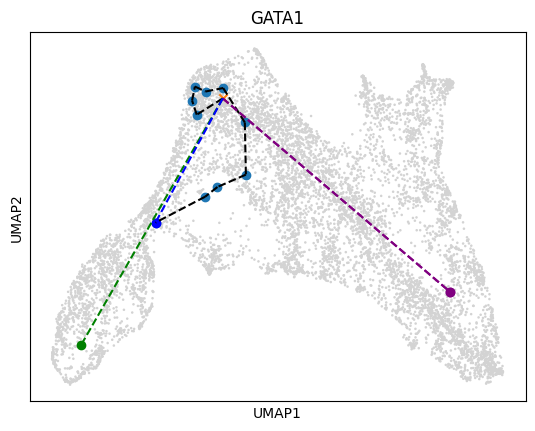

In [ ]:
gene = "GATA1"
centroid_gene = df_centroids.loc[f"{gene}_{10}",:]

fig, ax = plt.subplots()
sc.pl.umap(adata_ori, ax=ax, show=False)
plot_centroids(gene, ax)

ax.scatter(Erythrocyte_centroid[0],Erythrocyte_centroid[1], marker='o',color='green')
ax.plot([HSC_centroid[0], Erythrocyte_centroid[0]], 
                 [HSC_centroid[1], Erythrocyte_centroid[1]], 
                 color='green', linestyle='--')

ax.scatter(GMP_centroid[0],GMP_centroid[1], marker='o',color='purple')
ax.plot([HSC_centroid[0], GMP_centroid[0]], 
                 [HSC_centroid[1], GMP_centroid[1]], 
                 color='purple', linestyle='--')

ax.scatter(GMP_centroid[0],GMP_centroid[1], marker='o',color='purple')
ax.plot([HSC_centroid[0], GMP_centroid[0]], 
                 [HSC_centroid[1], GMP_centroid[1]], 
                 color='purple', linestyle='--')

ax.scatter(centroid_gene[0],centroid_gene[1], marker='o',color='blue')
ax.plot([HSC_centroid[0], centroid_gene[0]], 
                 [HSC_centroid[1], centroid_gene[1]], 
                 color='blue', linestyle='--')

## SPI1

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_right",ascending=False).index)=="SPI1")

(array([28]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("score_right",ascending=False).index)=="SPI1")

(array([2]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_right_FC",ascending=False).index)=="SPI1")

(array([21]),)

In [ ]:
np.where(np.array(df_average_score_TF.sort_values("cos_right_FC2",ascending=False).index)=="SPI1")

(array([8]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_right",ascending=False).index)=="SPI1")

(array([38]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("score_right",ascending=False).index)=="SPI1")

(array([12]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_right_FC",ascending=False).index)=="SPI1")

(array([47]),)

In [ ]:
np.where(np.array(df_average_score_TF2.sort_values("cos_right_FC2",ascending=False).index)=="SPI1")

(array([28]),)

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


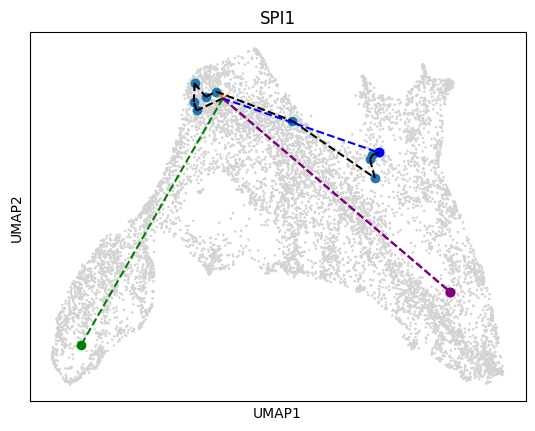

In [ ]:
gene = "SPI1"
centroid_gene = df_centroids.loc[f"{gene}_{10}",:]

fig, ax = plt.subplots()
sc.pl.umap(adata_ori, ax=ax, show=False)
plot_centroids(gene, ax)

ax.scatter(Erythrocyte_centroid[0],Erythrocyte_centroid[1], marker='o',color='green')
ax.plot([HSC_centroid[0], Erythrocyte_centroid[0]], 
                 [HSC_centroid[1], Erythrocyte_centroid[1]], 
                 color='green', linestyle='--')

ax.scatter(GMP_centroid[0],GMP_centroid[1], marker='o',color='purple')
ax.plot([HSC_centroid[0], GMP_centroid[0]], 
                 [HSC_centroid[1], GMP_centroid[1]], 
                 color='purple', linestyle='--')

ax.scatter(GMP_centroid[0],GMP_centroid[1], marker='o',color='purple')
ax.plot([HSC_centroid[0], GMP_centroid[0]], 
                 [HSC_centroid[1], GMP_centroid[1]], 
                 color='purple', linestyle='--')

ax.scatter(centroid_gene[0],centroid_gene[1], marker='o',color='blue')
ax.plot([HSC_centroid[0], centroid_gene[0]], 
                 [HSC_centroid[1], centroid_gene[1]], 
                 color='blue', linestyle='--')

Text(0, 0.5, 'score_branch_GMP')

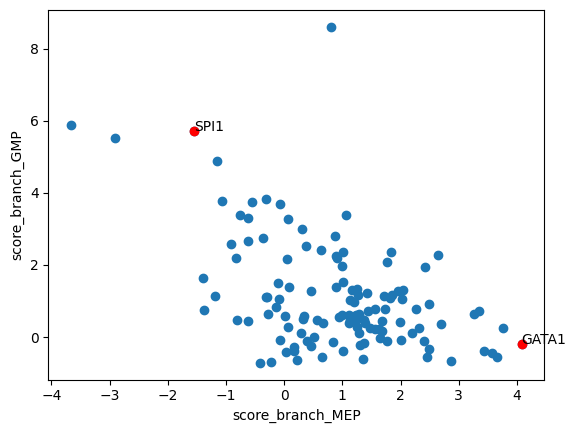

In [8]:
plt.scatter(df_average_score_TF.score_left, df_average_score_TF.score_right)

plt.scatter(df_average_score_TF.score_left['GATA1'], df_average_score_TF.score_right['GATA1'],color='red')
plt.text(df_average_score_TF.score_left['GATA1'], df_average_score_TF.score_right['GATA1'],'GATA1')

plt.scatter(df_average_score_TF.score_left['SPI1'], df_average_score_TF.score_right['SPI1'],color='red')
plt.text(df_average_score_TF.score_left['SPI1'], df_average_score_TF.score_right['SPI1'],'SPI1')

plt.xlabel("score_branch_MEP")
plt.ylabel("score_branch_GMP")

## top TFs

In [9]:
df_average_score_TF.sort_values("score_left",ascending=False).index[0:20]

Index(['GATA1', 'HEYL', 'RUNX1', 'TSHZ2', 'NFATC2', 'RORB', 'BCL11A', 'PRDM16',
       'TBX18', 'SOX4', 'ZNF831', 'NR2F2', 'RFX4', 'MYBL1', 'PROX1', 'TBX2',
       'RUNX2', 'FOXO1', 'POU2F2', 'MXD1'],
      dtype='object')

In [159]:
df_average_score_TF.sort_values("score_right",ascending=False).index[0:20]

CategoricalIndex(['LTF', 'SPIB', 'SPI1', 'IRF8', 'ZNF683', 'FOXS1', 'PAX5',
                  'TFEC', 'ZFPM2', 'HES4', 'CEBPD', 'POU2AF1', 'HES5',
                  'ZNF804A', 'SOX6', 'OLIG2', 'IRF4', 'EBF1', 'YBX3', 'TBX21'],
                 categories=['A2M', 'ABCA1', 'ABCA6', 'ABCA8', ..., 'ZNF683', 'ZNF804A', 'ZNF804B', 'ZNF831'], ordered=False, dtype='category')

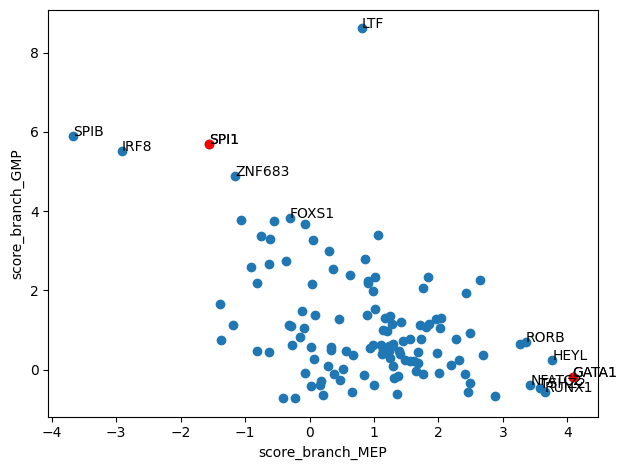

In [16]:
plt.scatter(df_average_score_TF.score_left, df_average_score_TF.score_right)

plt.scatter(df_average_score_TF.score_left['GATA1'], df_average_score_TF.score_right['GATA1'],color='red')
plt.text(df_average_score_TF.score_left['GATA1'], df_average_score_TF.score_right['GATA1'],'GATA1')

plt.scatter(df_average_score_TF.score_left['SPI1'], df_average_score_TF.score_right['SPI1'],color='red')
plt.text(df_average_score_TF.score_left['SPI1'], df_average_score_TF.score_right['SPI1'],'SPI1')


for gene in ['GATA1', 'HEYL', 'RUNX1', 'TSHZ2', 'NFATC2', 'RORB',
             'LTF', 'SPIB', 'SPI1', 'IRF8', 'ZNF683', 'FOXS1']:
    plt.text(df_average_score_TF.score_left[gene], df_average_score_TF.score_right[gene], gene)
    
plt.xlabel("score_branch_MEP")
plt.ylabel("score_branch_GMP")
plt.tight_layout()
plt.savefig("figures/Figure6c.pdf")